In [1]:
import sys, os
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
from tqdm.notebook import tqdm, trange
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import mean_squared_error

In [3]:
sys.path.append("../")

In [4]:
from Transformers import ChannelsFirst, ToTensor, Cut, Rescale, splitter_train_val_test

In [5]:
from DataSets import UNetDatasetFromFolders

In [6]:
from cUNet_pytorch_pooling import cUNet, dice_loss

In [7]:
DATA_DIR_DEEPTHOUGHT="/storage/yw18581/data"
data_dir = DATA_DIR_DEEPTHOUGHT

In [8]:
model_name = "../model/trained_cUNet_pytorch_regression_complete_dataset_100epochs_coeff_mask0.75_validation.pkl"

In [9]:
model_inference = cUNet(out_size=1)

In [10]:
model_inference.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
root_folder = os.path.join(data_dir, "dataset")

In [13]:
composed = transforms.Compose([Cut(), Rescale(.25), ChannelsFirst(), ToTensor()])

In [14]:
complete_dataset = UNetDatasetFromFolders(root_folder, transform=composed)

In [15]:
data_loaders, data_lengths = splitter_train_val_test(complete_dataset,
                                                    validation_split=0.2,
                                                    test_split=0.2,
                                                    batch=16,
                                                    workers=4)

In [16]:
data_lengths

{'train': 5717, 'val': 1429, 'test': 1786}

In [17]:
model_inference.eval()
model_inference.to(device);

batch 1
1: true_dist: 15, pred_dist: [14.945202]


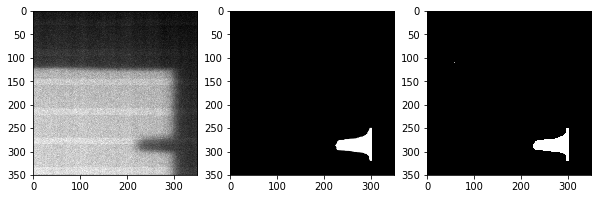

2: true_dist: 10, pred_dist: [10.018744]


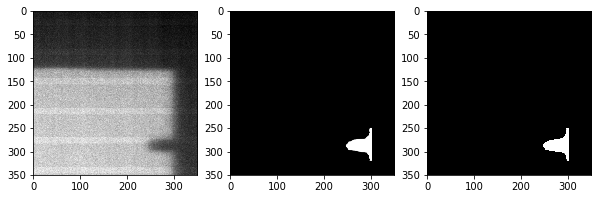

3: true_dist: 4, pred_dist: [3.9562347]


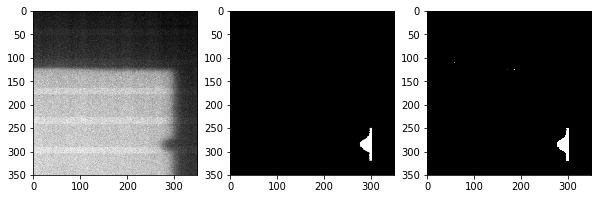

4: true_dist: 30, pred_dist: [30.085281]


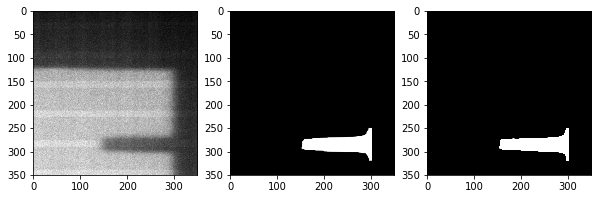

5: true_dist: 3, pred_dist: [3.1025908]


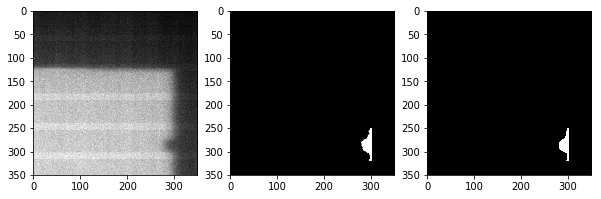

6: true_dist: 4, pred_dist: [3.9941952]


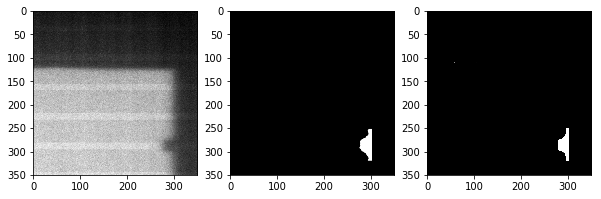

7: true_dist: 25, pred_dist: [24.96461]


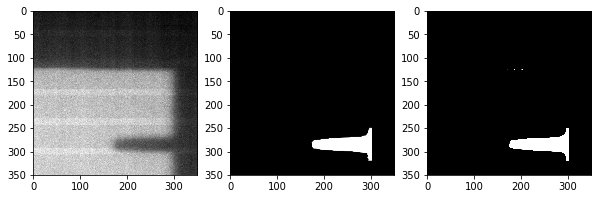

8: true_dist: 25, pred_dist: [25.04791]


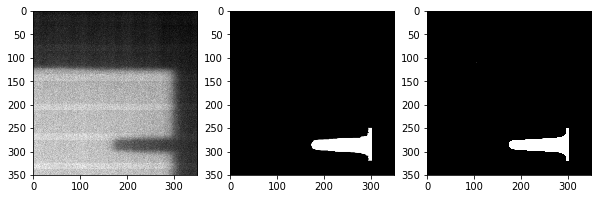

9: true_dist: 25, pred_dist: [24.990938]


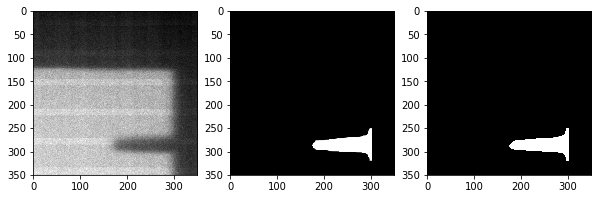

10: true_dist: 1, pred_dist: [1.082205]


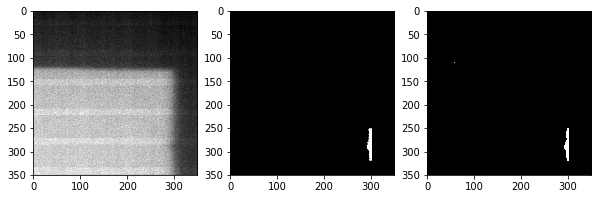

11: true_dist: 30, pred_dist: [30.103285]


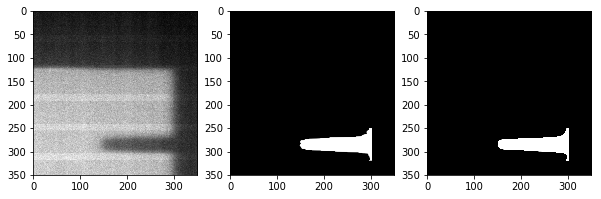

12: true_dist: 2, pred_dist: [2.0787456]


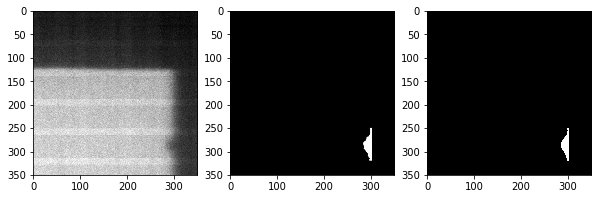

13: true_dist: 35, pred_dist: [34.997227]


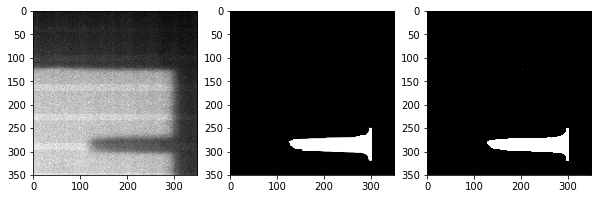

14: true_dist: 30, pred_dist: [30.101997]


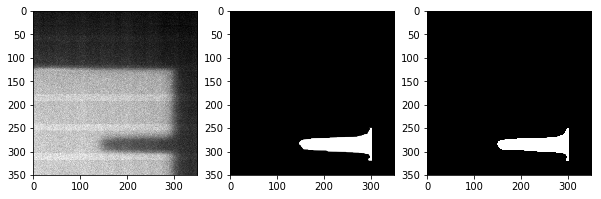

15: true_dist: 15, pred_dist: [14.96326]


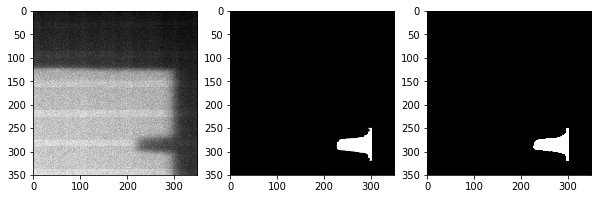

16: true_dist: 2, pred_dist: [2.0966635]


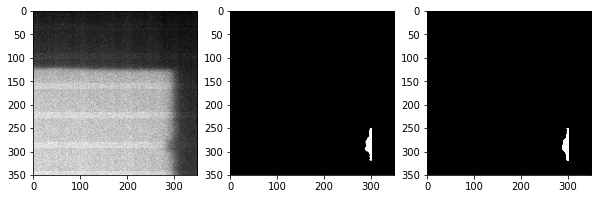

batch 2
1: true_dist: 10, pred_dist: [10.035879]


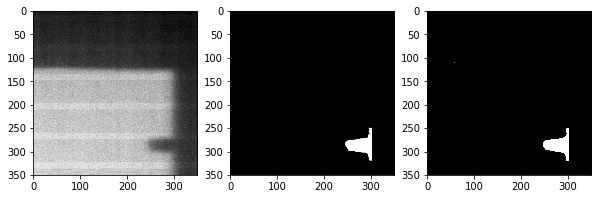

2: true_dist: 1, pred_dist: [1.063996]


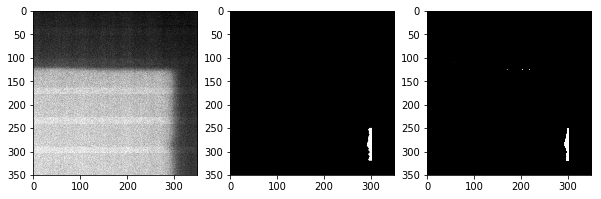

3: true_dist: 15, pred_dist: [14.98395]


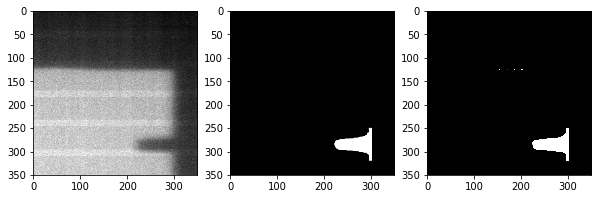

4: true_dist: 4, pred_dist: [3.9937015]


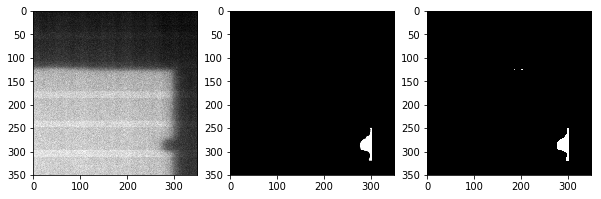

5: true_dist: 2, pred_dist: [2.1245532]


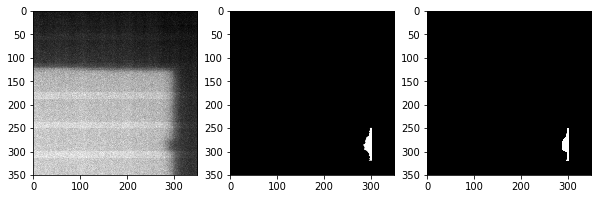

6: true_dist: 10, pred_dist: [10.019339]


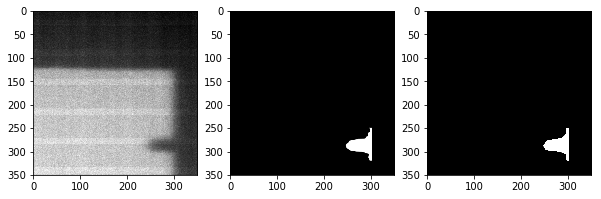

7: true_dist: 20, pred_dist: [19.980783]


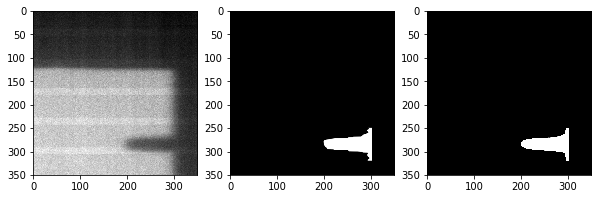

8: true_dist: 2, pred_dist: [2.1005359]


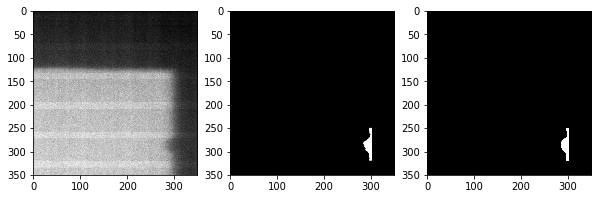

9: true_dist: 35, pred_dist: [35.050354]


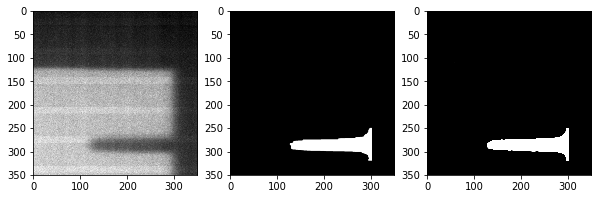

10: true_dist: 25, pred_dist: [25.108446]


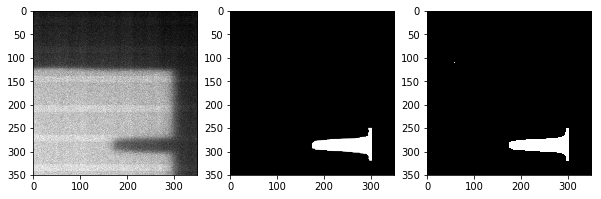

11: true_dist: 20, pred_dist: [20.019676]


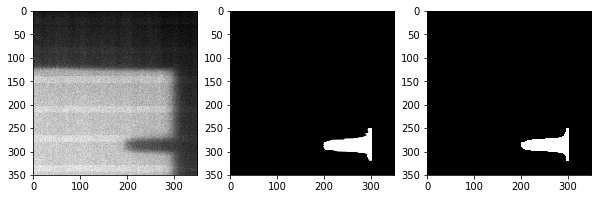

12: true_dist: 3, pred_dist: [3.1236143]


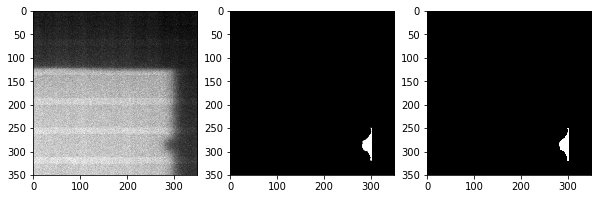

13: true_dist: 35, pred_dist: [35.051624]


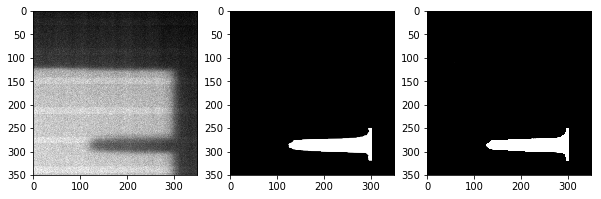

14: true_dist: 1, pred_dist: [1.1720419]


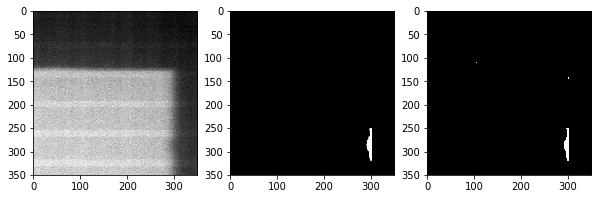

15: true_dist: 10, pred_dist: [9.983811]


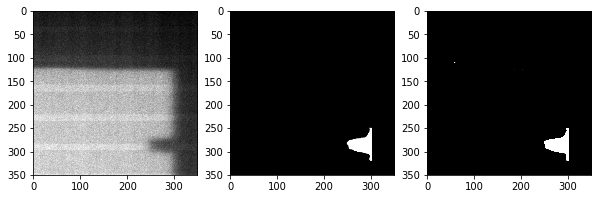

16: true_dist: 30, pred_dist: [29.979269]


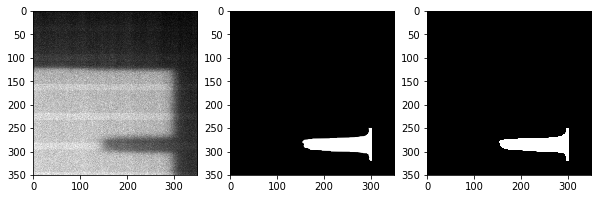

In [18]:
for i, batch in enumerate(data_loaders['test']):

    true_images, true_masks, true_dists = batch['image'], batch['mask'], batch['dist']
    pred_masks, pred_dists = model_inference(true_images.float().to(device))
    print("batch {}".format(i+1))
    for j, (img, tr_msk, tr_dist, pr_msk, pr_dist) in enumerate(zip(true_images,
                                                 true_masks, 
                                                 true_dists.cpu().detach().numpy(),
                                                 pred_masks.cpu().detach().numpy(), 
                                                 pred_dists.cpu().detach().numpy())):
    
        true_dist = tr_dist
        pred_dist = pr_dist
        print("{}: true_dist: {}, pred_dist: {}".format(j+1, true_dist, pred_dist))
        
        f = plt.figure(figsize=(10,5))
        f.add_subplot(1,3, 1)
        plt.imshow(img[0,...], cmap='gray')
        f.add_subplot(1,3, 2)
        plt.imshow(tr_msk[0,...], cmap='gray')
        f.add_subplot(1,3, 3)
        plt.imshow(pr_msk[0,...], cmap='gray')
        plt.show(block=True)
        
    if i==1:
        break

In [18]:
batch_size=16

In [19]:
y_true = []
y_pred = []

for i, batch in tqdm(enumerate(data_loaders['test']), total = data_lengths['test']//batch_size, desc = "Mini Batch"):
    true_images, true_dists = batch['image'], batch['dist']
    _, pred_dists = model_inference(true_images.float().to(device))
#    print("batch {}".format(i + 1))
    for j, (img, tr_dist, pr_dist) in enumerate(zip(true_images,
                                                true_dists.cpu().detach().numpy(),
                                                pred_dists.cpu().detach().numpy())):
        true_dist = tr_dist
        pred_dist = pr_dist
        y_true.append(true_dist)
        y_pred.append(pred_dist)




In [20]:
y_pred = np.asarray(y_pred).ravel()
y_true = np.asarray(y_true)

print("mse: {}".format(mean_squared_error(y_true, y_pred)))

mse: 0.006424104807748065


In [21]:
def get_idx(arr, key):
    return np.where(arr==key)[0]

In [22]:
def idx_mse(dist, true_arr = y_true, preds_arr = y_pred):
    idx = np.where(true_arr==dist)[0]
    mse = mean_squared_error(true_arr[idx], preds_arr[idx])
    print(dist, mse)
    return idx, mse 

In [23]:
idx_1, mse_1 = idx_mse(1)
idx_2, mse_2 = idx_mse(2)
idx_3, mse_3 = idx_mse(3)
idx_4, mse_4 = idx_mse(4)
idx_10, mse_10 = idx_mse(10)
idx_15, mse_15 = idx_mse(15)
idx_20, mse_20 = idx_mse(20)
idx_25, mse_25 = idx_mse(25)
idx_30, mse_30 = idx_mse(30)
idx_35, mse_35 = idx_mse(35)

1 0.015216936322193208
2 0.005157991209721359
3 0.006907636715640229
4 0.00608427163286921
10 0.0023260467607206406
15 0.0031659477688576036
20 0.0077357391045425866
25 0.00587127405365448
30 0.005928827807413957
35 0.004904994428397913


In [25]:
distances = [1,2,3,4,10,15,20,25,30,35]

In [26]:
errors = [idx_mse(i)[1] for i in distances]

1 0.015216936322193208
2 0.005157991209721359
3 0.006907636715640229
4 0.00608427163286921
10 0.0023260467607206406
15 0.0031659477688576036
20 0.0077357391045425866
25 0.00587127405365448
30 0.005928827807413957
35 0.004904994428397913


(0, 0.05)

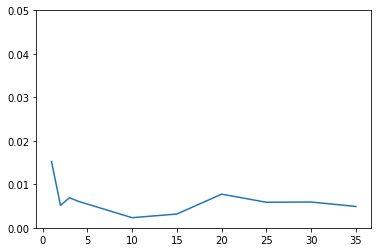

In [27]:
plt.plot(distances, errors)
plt.ylim((0,0.05))

In [28]:
np.savez_compressed("Predicted_ALL_out_model_trained_on_ALLDATA_100_epochs.npz", true=y_true, pred = y_pred)